In [56]:
%matplotlib inline

In [77]:
from pyqubo import Array, Constraint, solve_qubo
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# 頂点の数を定義します。
N_VER = 8
# 色の数を定義します。
N_COLOR = 4
# グラフを定義します。0~7の頂点があったときにどの頂点同士が線で結ばれているかを定義しています。
graph = [(0,1), (0,2), (1,2), (5,6), (2,3), (2,5), (3,4), (5,7), (7, 6)]

In [4]:
x = Array.create('x', shape=(N_VER,N_COLOR), vartype='BINARY')

In [8]:
# 第一項 (制約項)を定義します。
H_A = Constraint(sum((1-sum(x[v,i] for i in range(1,N_COLOR)))**2 for v in range(N_VER)), label='HA')
# 第二項 (コスト、目的関数)を定義します。
H_B = sum((-1+sum(x[v,i] for v in range (N_VER)))/2*(sum(x[v,i] for v in range (N_VER))) - sum(x[u,i]*x[v,i] for (u,v) in graph) for i in range (1,N_COLOR))
# ハミルトニアン全体を定義します。
Q = H_A+H_B

In [21]:
# モデルをコンパイルします。
model = Q.compile()
qubo, offset = model.to_qubo()

In [27]:
import neal

In [28]:
sampler = neal.SimulatedAnnealingSampler()
raw_solution = sampler.sample_qubo(qubo)
print(raw_solution)

  x[0][1] x[0][2] x[0][3] x[1][1] x[1][2] x[1][3] ... x[7][3] energy num_oc.
0       1       0       0       1       0       0 ...       0   -8.0       1
['BINARY', 1 rows, 1 samples, 24 variables]


In [37]:
decoded_sample.sample

{'x[0][1]': 1,
 'x[0][2]': 0,
 'x[3][3]': 1,
 'x[2][1]': 1,
 'x[0][3]': 0,
 'x[3][2]': 0,
 'x[1][1]': 1,
 'x[1][2]': 0,
 'x[1][3]': 0,
 'x[2][2]': 0,
 'x[2][3]': 0,
 'x[3][1]': 0,
 'x[4][1]': 0,
 'x[4][2]': 0,
 'x[7][3]': 0,
 'x[4][3]': 1,
 'x[7][2]': 1,
 'x[5][1]': 0,
 'x[5][2]': 1,
 'x[5][3]': 0,
 'x[6][1]': 0,
 'x[6][2]': 1,
 'x[6][3]': 0,
 'x[7][1]': 0}

In [29]:
# 得られた結果をデコードします。
decoded_sample = model.decode_sample(raw_solution.first.sample, vartype="BINARY")
# さらに解を見やすくする処理を追加します。
# .array(変数名, 要素番号)で希望する要素の値を抽出することができます。
x_solution = {}
for i in range(N_VER):
    x_solution[i] = {}
    for j in range(1,N_COLOR):
        x_solution[i][j] = decoded_sample.array('x', (i, j))
x_solution

{0: {1: 1, 2: 0, 3: 0},
 1: {1: 1, 2: 0, 3: 0},
 2: {1: 1, 2: 0, 3: 0},
 3: {1: 0, 2: 0, 3: 1},
 4: {1: 0, 2: 0, 3: 1},
 5: {1: 0, 2: 1, 3: 0},
 6: {1: 0, 2: 1, 3: 0},
 7: {1: 0, 2: 1, 3: 0}}

In [83]:
decoded_sample.sample

{'x[0][1]': 1,
 'x[0][2]': 0,
 'x[3][3]': 1,
 'x[2][1]': 1,
 'x[0][3]': 0,
 'x[3][2]': 0,
 'x[1][1]': 1,
 'x[1][2]': 0,
 'x[1][3]': 0,
 'x[2][2]': 0,
 'x[2][3]': 0,
 'x[3][1]': 0,
 'x[4][1]': 0,
 'x[4][2]': 0,
 'x[7][3]': 0,
 'x[4][3]': 1,
 'x[7][2]': 1,
 'x[5][1]': 0,
 'x[5][2]': 1,
 'x[5][3]': 0,
 'x[6][1]': 0,
 'x[6][2]': 1,
 'x[6][3]': 0,
 'x[7][1]': 0}

In [82]:
decoded_sample.constraints(only_broken=True)

{}

In [38]:
decoded_sample.constraints(only_broken=True)

{}

In [39]:
# OpenJijをインポートします。
import openjij as oj

# SQAを用いて問題を解きます。
sampler = oj.SQASampler()
# QUBOに先ほど.to_quboで作成したものを代入します。
response = sampler.sample_qubo(Q=qubo)
print(response)

  x[0][1] x[0][2] x[0][3] x[1][1] x[1][2] x[1][3] ... x[7][3] energy num_oc.
0       0       0       1       0       0       1 ...       0   -8.0       1
['BINARY', 1 rows, 1 samples, 24 variables]


In [50]:
res = oj.SQASampler(num_sweeps=1000, num_reads=num_reads).sample_qubo(Q=qubo)

In [53]:
# num_sweepsとnum_readsの反復数を与えます。
# num_sweeps_list = list(range(10, 51, 10))  # [10, 20, 30, 40, 50]
num_sweeps_list = [30, 50, 80, 100, 150, 200]
num_reads = 1000

# benchmark関数を用いてTTS, 残留エネルギー, 成功確率を計算します。
result = oj.solver_benchmark(                  
    solver=lambda time, **args: oj.\
    SQASampler(num_sweeps=time, num_reads=num_reads)\
    .sample_qubo(Q=qubo),
    solutions = [[]],
    time_list=num_sweeps_list, p_r=0.99, 
)

Text(0, 0.5, 'Success probability')

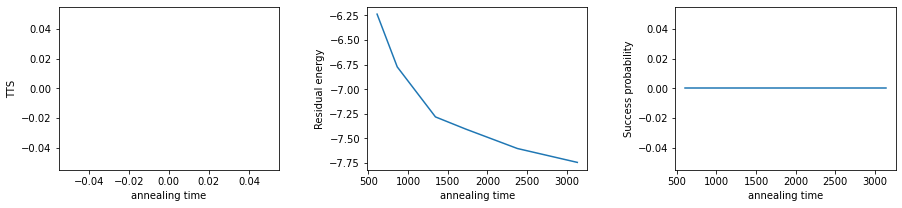

In [58]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['residual_energy'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['success_prob'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

In [61]:
# エネルギーが一番低い状態を取り出します。
dict_solution = response.first.sample
# 得られた結果をデコードします。
decoded_sample = model.decode_sample(raw_solution.first.sample, vartype="BINARY")
# さらに解を見やすくする処理を追加します。
# .array(変数名, 要素番号)で希望する要素の値を抽出することができます。
x_solution = {}
for i in range(N_VER):
    x_solution[i] = {}
    for j in range(1,N_COLOR):
        x_solution[i][j] = decoded_sample.array('x', (i, j))
x_solution

{0: {1: 1, 2: 0, 3: 0},
 1: {1: 1, 2: 0, 3: 0},
 2: {1: 1, 2: 0, 3: 0},
 3: {1: 0, 2: 0, 3: 1},
 4: {1: 0, 2: 0, 3: 1},
 5: {1: 0, 2: 1, 3: 0},
 6: {1: 0, 2: 1, 3: 0},
 7: {1: 0, 2: 1, 3: 0}}

In [78]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()